![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
plt.style.use('fivethirtyeight')

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [3]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [4]:
epidemic_duration_in_days = 365

Tamanho da população.

In [5]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [6]:
initially_infected = 52

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [7]:
target_location = 'Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [8]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [9]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [10]:
results_suffix = ''

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [11]:
# custom papermill parameters

In [12]:
# Parameters
target_location = "South Korea"
infer_parameters_from_data = True
results_suffix = ".south korea"


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [13]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    df_simulated_data = df_simulated_data[['S', 'E', 'I', 'R', 'E+I']]
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data)
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']])
    ax.set_title('Apenas Expostos e Infectados')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    if zoom_on is not None:
        zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
        ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
        if file_name is not None:
            ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
        ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
        plt.figure()

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [14]:
df_epidemy_data = pd.read_csv('../data/ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv('../data/ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')
df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population
0,2019-12-31,Afghanistan,0,0,0,0,Afghanistan,Asia,2020.0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,Afghanistan,Asia,2020.0,38928341.0


Selecionemos apenas dados sobre o país de interesse.

In [15]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2
date,,,,,,,,,,
2020-03-31,125,5,9786,163,South_Korea,Asia,2020.0,51269183.0,NaN,97860
2020-04-01,0,0,9786,163,South_Korea,Asia,2020.0,51269183.0,NaN,97860
2020-04-02,190,6,9976,169,South_Korea,Asia,2020.0,51269183.0,NaN,99760
2020-04-03,86,5,10062,174,South_Korea,Asia,2020.0,51269183.0,NaN,100620
2020-04-04,94,3,10156,177,South_Korea,Asia,2020.0,51269183.0,NaN,101560


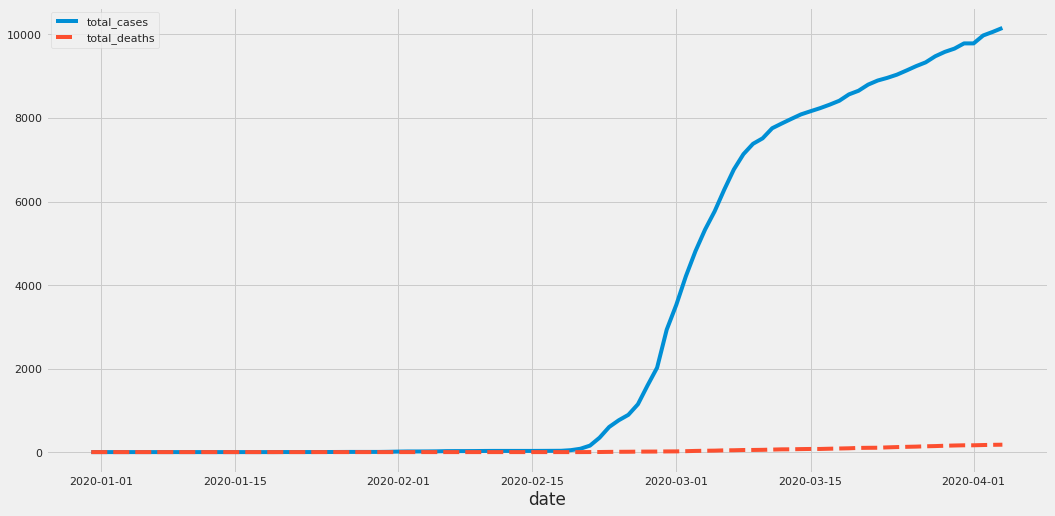

In [16]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 10 * df_data_target['total_cases']

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [17]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-02-20 00:00:00')

In [18]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-02-20 00:00:00, population_size=51269183.0, initially_infected=80


Filtremos os dados a partir da data de interesse.

In [19]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [20]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [21]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [22]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    for value, length in regimens:
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [23]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [24]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [25]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [26]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [27]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [28]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

### Simulação

A simulação então pode ser definida do seguinte modo.

In [29]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func):
    
    generated_data = [] # initial data
    
    E_delta = 0
    I_delta = 0 # changes start at 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [30]:
alpha = 1.0   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,E+I
2020-02-20,5.126910e+07,80.000000,0.000000,0.000000,0.000000,0.00000,80.000000
2020-02-21,5.126910e+07,0.000000,0.000000,80.000000,80.000000,0.00000,80.000000
2020-02-22,5.126904e+07,63.999900,63.999900,56.000000,0.000000,24.00000,119.999900
2020-02-23,5.126899e+07,44.799874,44.799874,103.199900,63.999900,40.80000,147.999774
2020-02-24,5.126891e+07,82.559616,82.559616,117.039804,44.799874,71.75997,199.599420


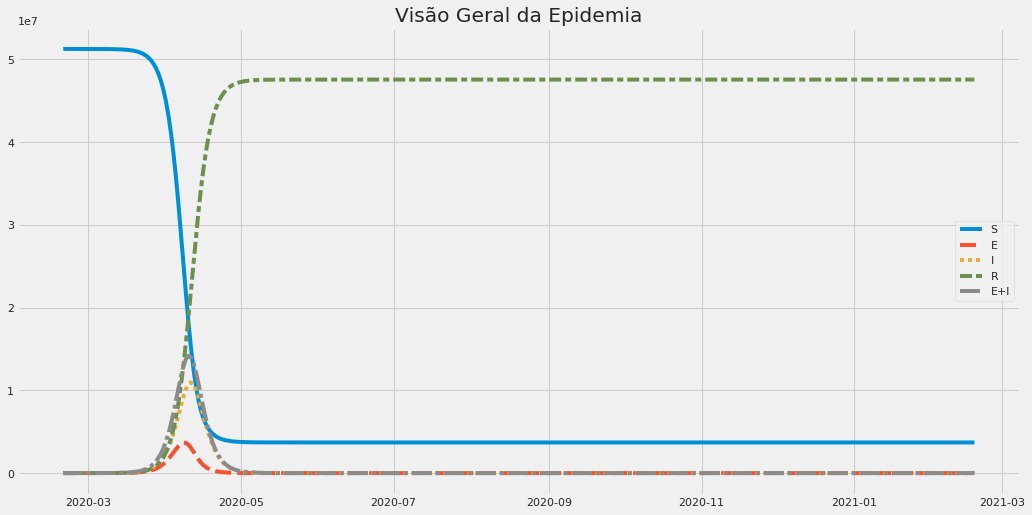

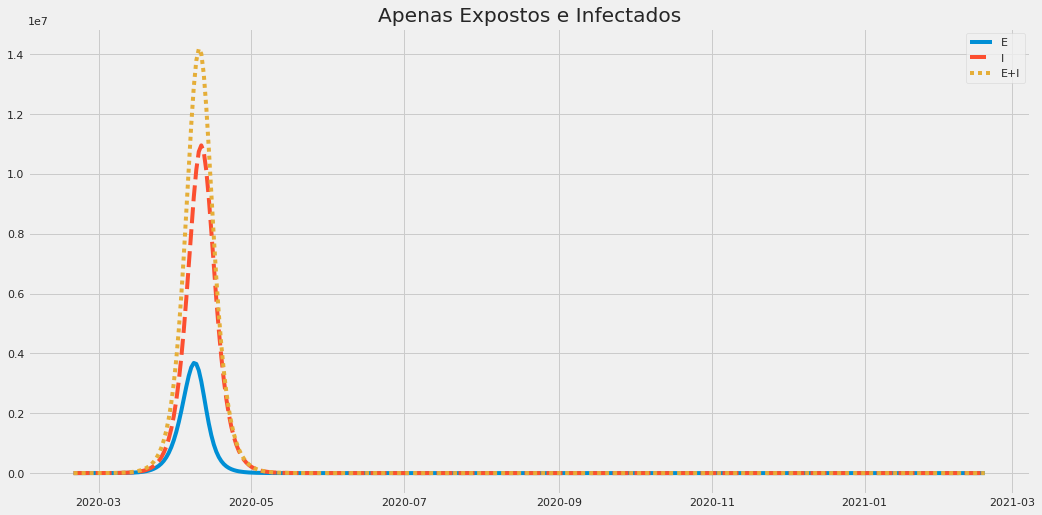

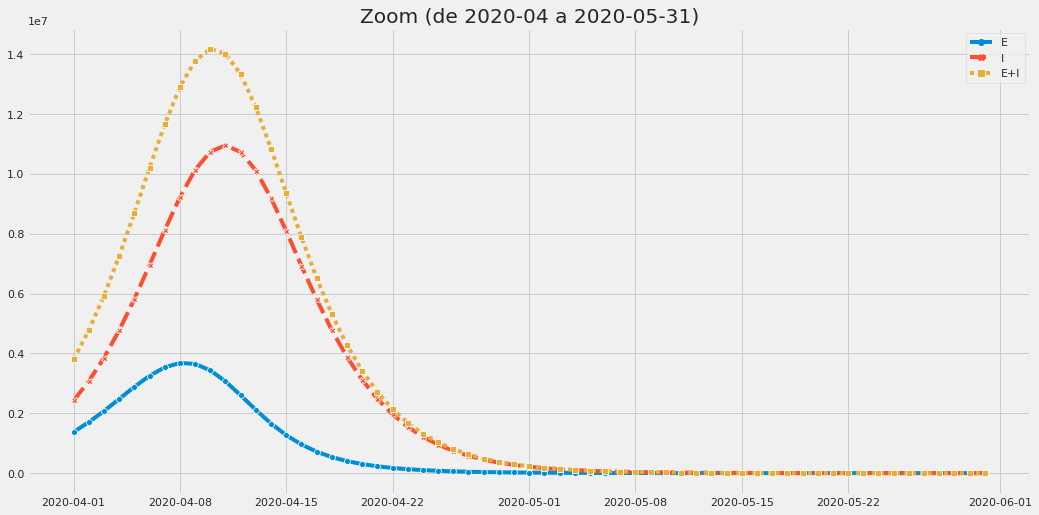

<Figure size 1152x576 with 0 Axes>

In [31]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

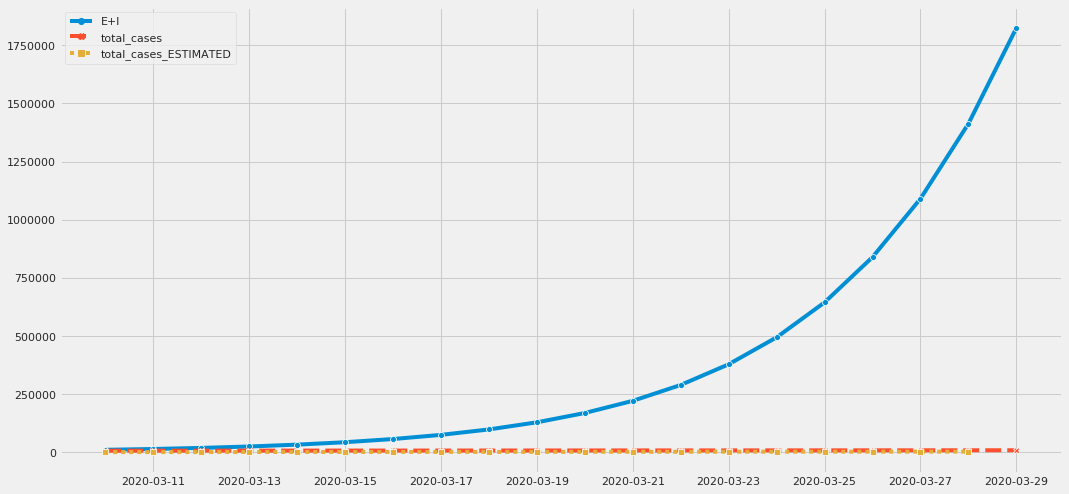

In [32]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [33]:
beta = dynamic_parameter([(0.3, 30), 
                          (0.1, 60), 
                          (0.05, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)


,S,E,E_delta,I,I_delta,R,E+I
2020-02-20,5.126910e+07,80.000000,0.000000,0.000000,0.000000,0.000000,80.000000
2020-02-21,5.126910e+07,0.000000,0.000000,80.000000,80.000000,0.000000,80.000000
2020-02-22,5.126908e+07,23.999963,23.999963,56.000000,0.000000,24.000000,79.999963
2020-02-23,5.126906e+07,16.799966,16.799966,63.199963,23.999963,40.800000,79.999928
2020-02-24,5.126904e+07,18.959944,18.959944,61.039940,16.799966,59.759989,79.999884


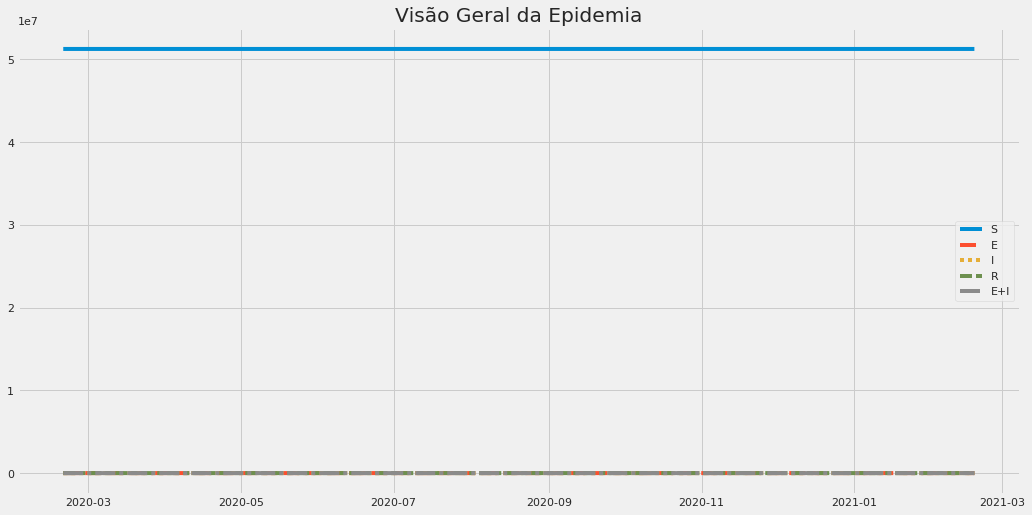

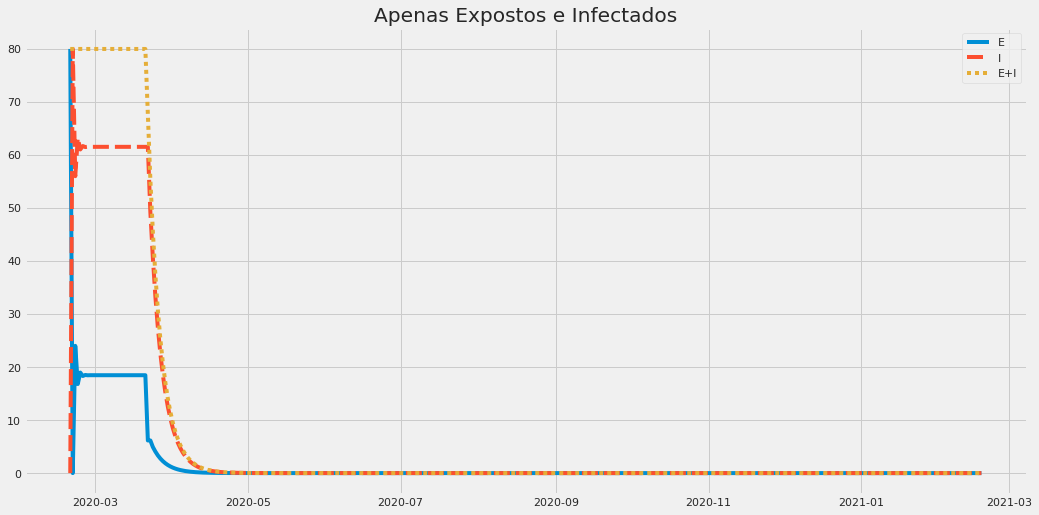

<Figure size 1152x576 with 0 Axes>

In [34]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [35]:
def objective_for_simulation(args):
    alpha, beta, gamma = args
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    df_diff_cases = df_data_target['total_cases_ESTIMATED'] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'])

    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [36]:
space = (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0))

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=300, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

  3%|▎         | 9/300 [00:00<00:03, 83.02trial/s, best loss: 771.4578100429825]

  6%|▌         | 18/300 [00:00<00:03, 82.98trial/s, best loss: 771.4578100429825]

  8%|▊         | 24/300 [00:00<00:03, 73.70trial/s, best loss: 771.4578100429825]

 10%|█         | 30/300 [00:00<00:04, 64.65trial/s, best loss: 771.4578100429825]

 12%|█▏        | 35/300 [00:00<00:04, 59.24trial/s, best loss: 771.4578100429825]

 13%|█▎        | 40/300 [00:00<00:04, 55.07trial/s, best loss: 771.4578100429825]

 15%|█▌        | 45/300 [00:00<00:04, 52.90trial/s, best loss: 771.4578100429825]

 17%|█▋        | 50/300 [00:00<00:04, 51.10trial/s, best loss: 738.9736066452488]

 18%|█▊        | 55/300 [00:00<00:04, 50.44trial/s, best loss: 720.9933388608239]

 20%|██        | 60/300 [00:01<00:04, 50.18trial/s, best loss: 720.9933388608239]

 22%|██▏       | 65/300 [00:01<00:04, 50.01trial/s, best loss: 720.9933388608239]

 24%|██▎       | 71/300 [00:01<00:04, 50.28trial/s, best loss: 720.9933388608239]

 25%|██▌       | 76/300 [00:01<00:04, 49.82trial/s, best loss: 720.9933388608239]

 27%|██▋       | 81/300 [00:01<00:04, 49.53trial/s, best loss: 720.9933388608239]

 29%|██▊       | 86/300 [00:01<00:04, 49.06trial/s, best loss: 720.9933388608239]

 30%|███       | 91/300 [00:01<00:04, 48.75trial/s, best loss: 720.9933388608239]

 32%|███▏      | 96/300 [00:01<00:04, 48.55trial/s, best loss: 720.9933388608239]

 34%|███▎      | 101/300 [00:01<00:04, 48.40trial/s, best loss: 720.9933388608239]

 35%|███▌      | 106/300 [00:02<00:04, 47.76trial/s, best loss: 720.9933388608239]

 37%|███▋      | 111/300 [00:02<00:03, 47.80trial/s, best loss: 720.9688470006796]

 39%|███▊      | 116/300 [00:02<00:03, 47.32trial/s, best loss: 720.9688470006796]

 40%|████      | 121/300 [00:02<00:03, 47.33trial/s, best loss: 720.9688470006796]

 42%|████▏     | 126/300 [00:02<00:03, 46.94trial/s, best loss: 720.9688470006796]

 44%|████▎     | 131/300 [00:02<00:03, 46.68trial/s, best loss: 720.9688470006796]

 45%|████▌     | 136/300 [00:02<00:03, 45.75trial/s, best loss: 720.9688470006796]

 47%|████▋     | 141/300 [00:02<00:03, 45.33trial/s, best loss: 720.9688470006796]

 49%|████▊     | 146/300 [00:02<00:03, 43.45trial/s, best loss: 720.9688470006796]

 50%|█████     | 151/300 [00:03<00:03, 44.39trial/s, best loss: 720.9688470006796]

 52%|█████▏    | 156/300 [00:03<00:03, 45.11trial/s, best loss: 720.9688470006796]

 54%|█████▎    | 161/300 [00:03<00:03, 44.81trial/s, best loss: 720.9688470006796]

 55%|█████▌    | 166/300 [00:03<00:03, 43.06trial/s, best loss: 720.9688470006796]

 57%|█████▋    | 171/300 [00:03<00:02, 44.13trial/s, best loss: 720.9688470006796]

 59%|█████▊    | 176/300 [00:03<00:02, 44.86trial/s, best loss: 720.9688470006796]

 60%|██████    | 181/300 [00:03<00:02, 45.05trial/s, best loss: 720.9688470006796]

 62%|██████▏   | 186/300 [00:03<00:02, 44.93trial/s, best loss: 720.9688470006796]

 64%|██████▎   | 191/300 [00:03<00:02, 44.78trial/s, best loss: 720.9688470006796]

 65%|██████▌   | 196/300 [00:04<00:02, 44.57trial/s, best loss: 720.9688470006796]

 67%|██████▋   | 201/300 [00:04<00:02, 44.53trial/s, best loss: 720.9688470006796]

 69%|██████▊   | 206/300 [00:04<00:02, 44.50trial/s, best loss: 720.9688470006796]

 70%|███████   | 211/300 [00:04<00:01, 44.53trial/s, best loss: 720.9688470006796]

 72%|███████▏  | 216/300 [00:04<00:01, 44.52trial/s, best loss: 720.9688470006796]

 74%|███████▎  | 221/300 [00:04<00:01, 44.16trial/s, best loss: 720.9688470006796]

 75%|███████▌  | 226/300 [00:04<00:01, 43.82trial/s, best loss: 720.9688470006796]

 77%|███████▋  | 231/300 [00:04<00:01, 41.92trial/s, best loss: 720.9688470006796]

 79%|███████▊  | 236/300 [00:04<00:01, 41.02trial/s, best loss: 720.9688470006796]

 80%|████████  | 241/300 [00:05<00:01, 41.60trial/s, best loss: 720.9688470006796]

 82%|████████▏ | 246/300 [00:05<00:01, 42.14trial/s, best loss: 720.9688470006796]

 84%|████████▎ | 251/300 [00:05<00:01, 42.46trial/s, best loss: 720.9688470006796]

 85%|████████▌ | 256/300 [00:05<00:01, 42.69trial/s, best loss: 720.9688470006796]

 87%|████████▋ | 261/300 [00:05<00:00, 42.67trial/s, best loss: 720.9688470006796]

 89%|████████▊ | 266/300 [00:05<00:00, 42.66trial/s, best loss: 720.9688470006796]

 90%|█████████ | 271/300 [00:05<00:00, 42.75trial/s, best loss: 720.9688470006796]

 92%|█████████▏| 276/300 [00:05<00:00, 42.88trial/s, best loss: 720.9688470006796]

 94%|█████████▎| 281/300 [00:06<00:00, 36.91trial/s, best loss: 720.9688470006796]

 95%|█████████▌| 286/300 [00:06<00:00, 38.39trial/s, best loss: 720.9688470006796]

 97%|█████████▋| 291/300 [00:06<00:00, 39.51trial/s, best loss: 720.9688470006796]

 99%|█████████▊| 296/300 [00:06<00:00, 39.41trial/s, best loss: 720.9688470006796]

100%|██████████| 300/300 [00:06<00:00, 46.02trial/s, best loss: 720.9688470006796]


Best parameters found: {'alpha': 0.9972646397162956, 'beta': 0.4621101034122605, 'gamma': 0.29198780609122094}


In [37]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,E+I
2020-03-16,5.126589e+07,369.416667,368.514717,893.479583,328.835364,2030.423165,1262.896250
2020-03-17,5.126548e+07,413.869908,412.859421,1001.000619,368.406179,2291.308308,1414.870528
2020-03-18,5.126501e+07,463.671144,462.539061,1121.458470,412.737825,2583.588283,1585.129614
2020-03-19,5.126450e+07,519.463459,518.195151,1256.409108,462.402837,2911.040481,1775.872567
2020-03-20,5.126392e+07,581.967185,580.546266,1407.595508,518.042539,3277.896620,1989.562694


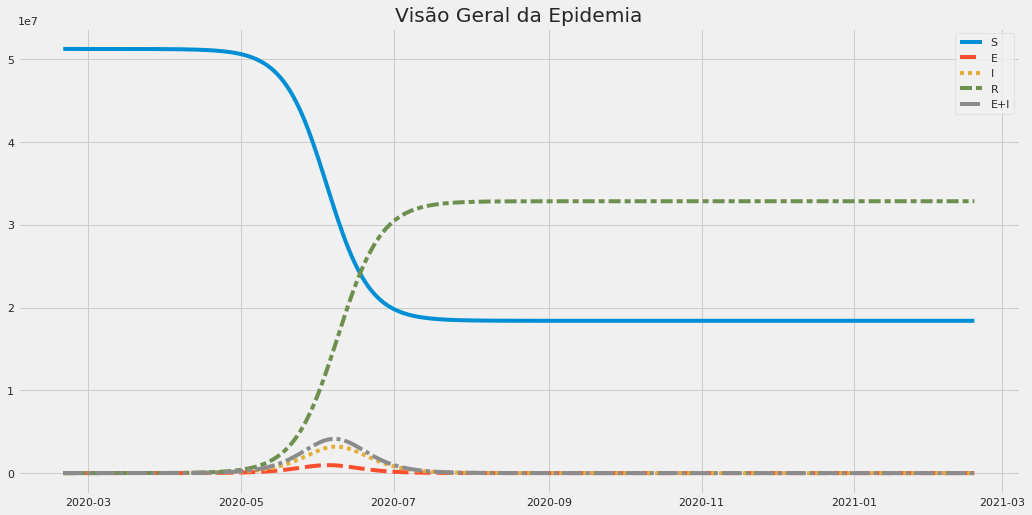

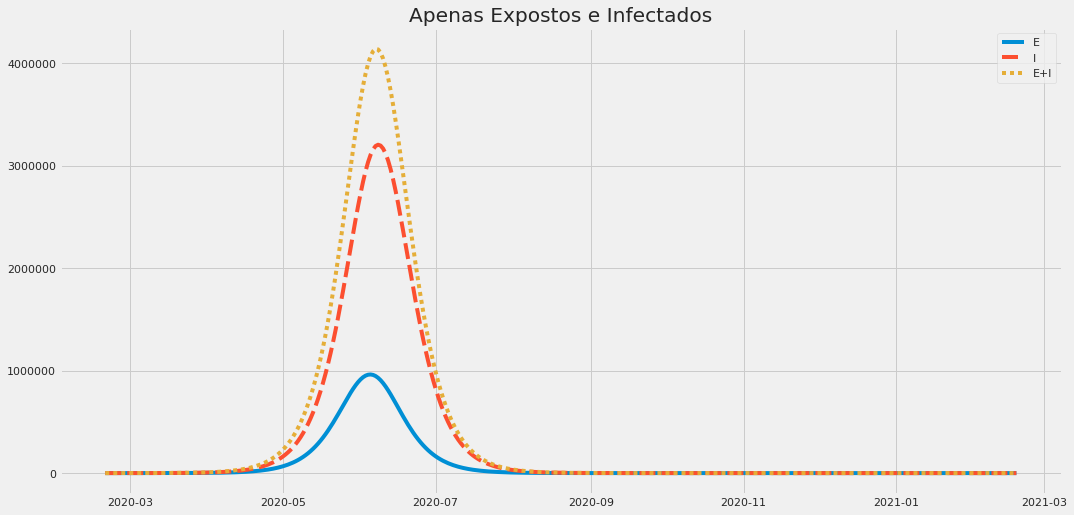

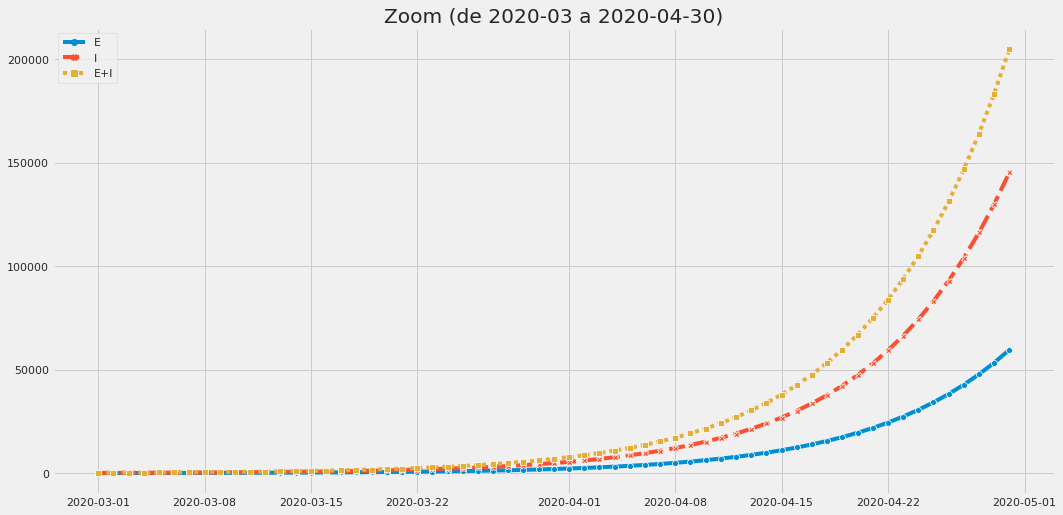

<Figure size 1152x576 with 0 Axes>

In [38]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-03', file_name='no-mitigation')
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [39]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2
date,,,,,,,,,,
2020-03-31,125,5,9786,163,South_Korea,Asia,2020.0,51269183.0,NaN,97860
2020-04-01,0,0,9786,163,South_Korea,Asia,2020.0,51269183.0,NaN,97860
2020-04-02,190,6,9976,169,South_Korea,Asia,2020.0,51269183.0,NaN,99760
2020-04-03,86,5,10062,174,South_Korea,Asia,2020.0,51269183.0,NaN,100620
2020-04-04,94,3,10156,177,South_Korea,Asia,2020.0,51269183.0,NaN,101560


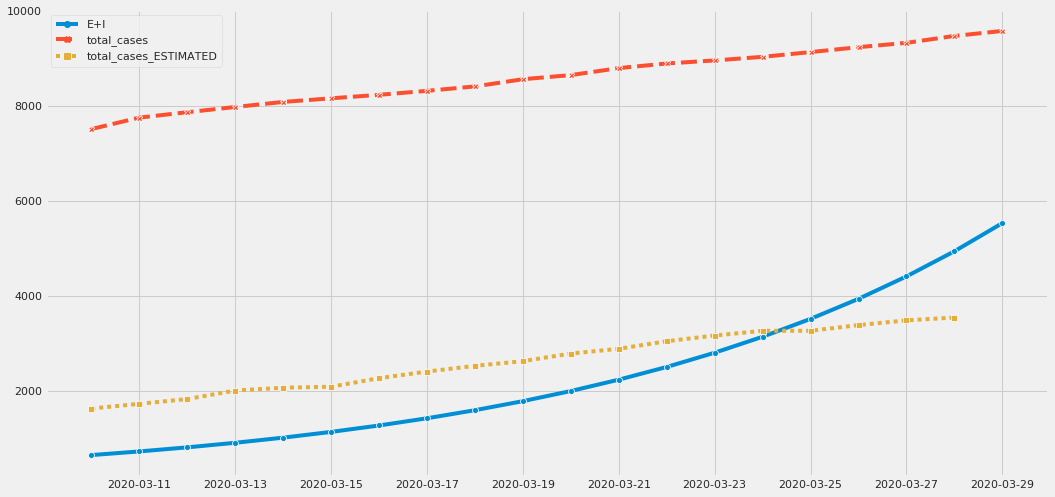

In [40]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Salvemos os resultados.

In [41]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo medidas de mitigação que reduzem o contágio após alguns dias iniciais com os parâmetros inferidos anteriormente.

In [42]:
#alpha = dynamic_parameter([(best['alpha'], 11), 
#                          (best['alpha']/1.8, 30), 
#                          (best['alpha']/2, epidemic_duration_in_days)],
#                         min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta'], 11), 
                          (best['beta']/1.7, 30), 
                          (best['beta']/1.1, epidemic_duration_in_days)],
                         min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

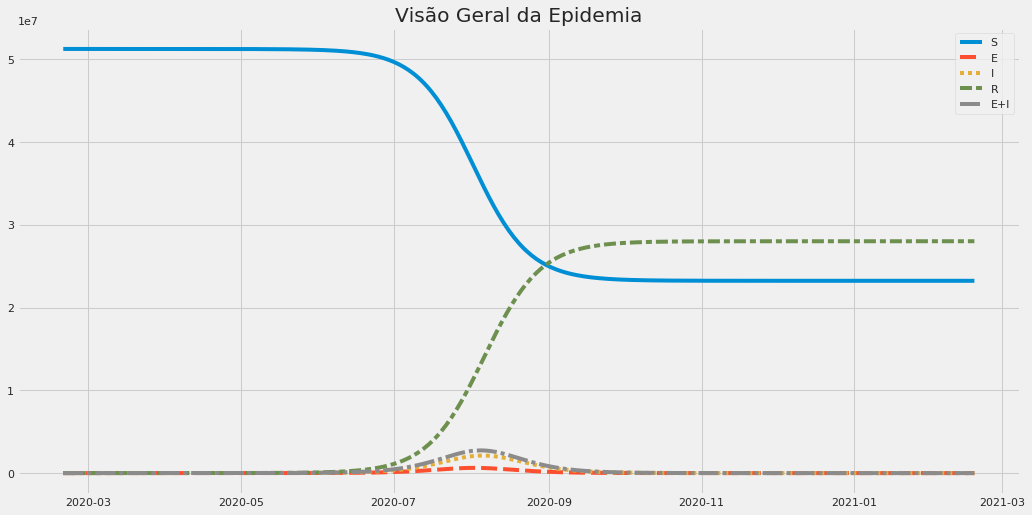

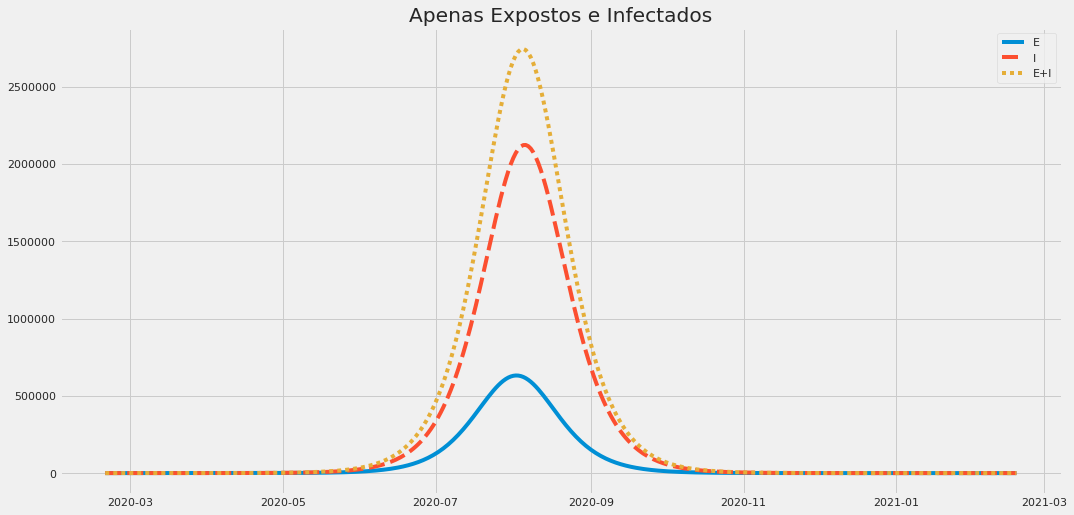

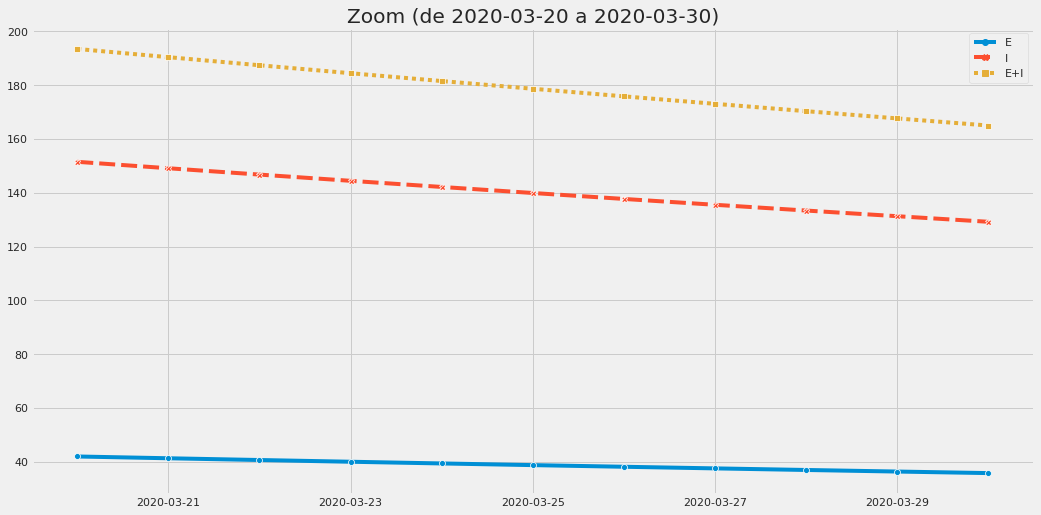

<Figure size 1152x576 with 0 Axes>

In [43]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_on='2020-03-20', zoom_length=10, file_name='with-mitigation')

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

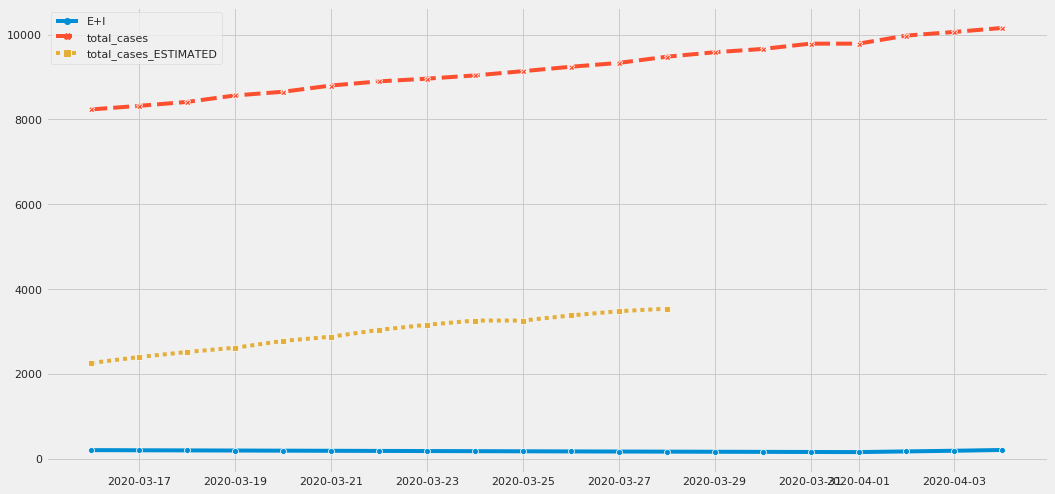

In [44]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_mitigated_vs_real = pd.concat([df_simulation_mitigation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_mitigated_vs_real[['E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Finalmente, comparemos os casos com e sem mitigação.

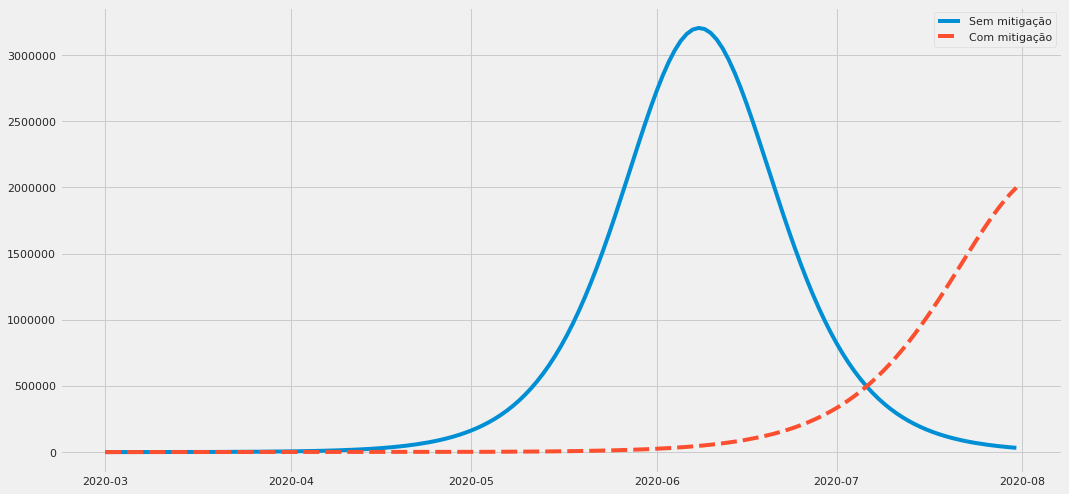

In [45]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['I'].rename('Com mitigação')], axis=1)['2020-03':'2020-07'])

ax.figure.savefig(results_folder + 'seir_mitigation_vs_no-mitigation' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [46]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_with_mitigation_model_output.{target_location.lower()}.csv')